In [17]:
#!sbatch k_over_N_src.SBATCH

Submitted batch job 49453274


In [31]:
#!squeue -u hl5398
!scancel 

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
        49453274_0   rtx8000 null_avg   hl5398  R      44:42      1 gr003
        49453274_1   rtx8000 null_avg   hl5398  R      44:42      1 gr045
        49453274_2   rtx8000 null_avg   hl5398  R      44:42      1 gr049
        49453274_3   rtx8000 null_avg   hl5398  R      44:42      1 gr052
          49426981     short ood-jupy   hl5398  R    3:35:47      1 cm031


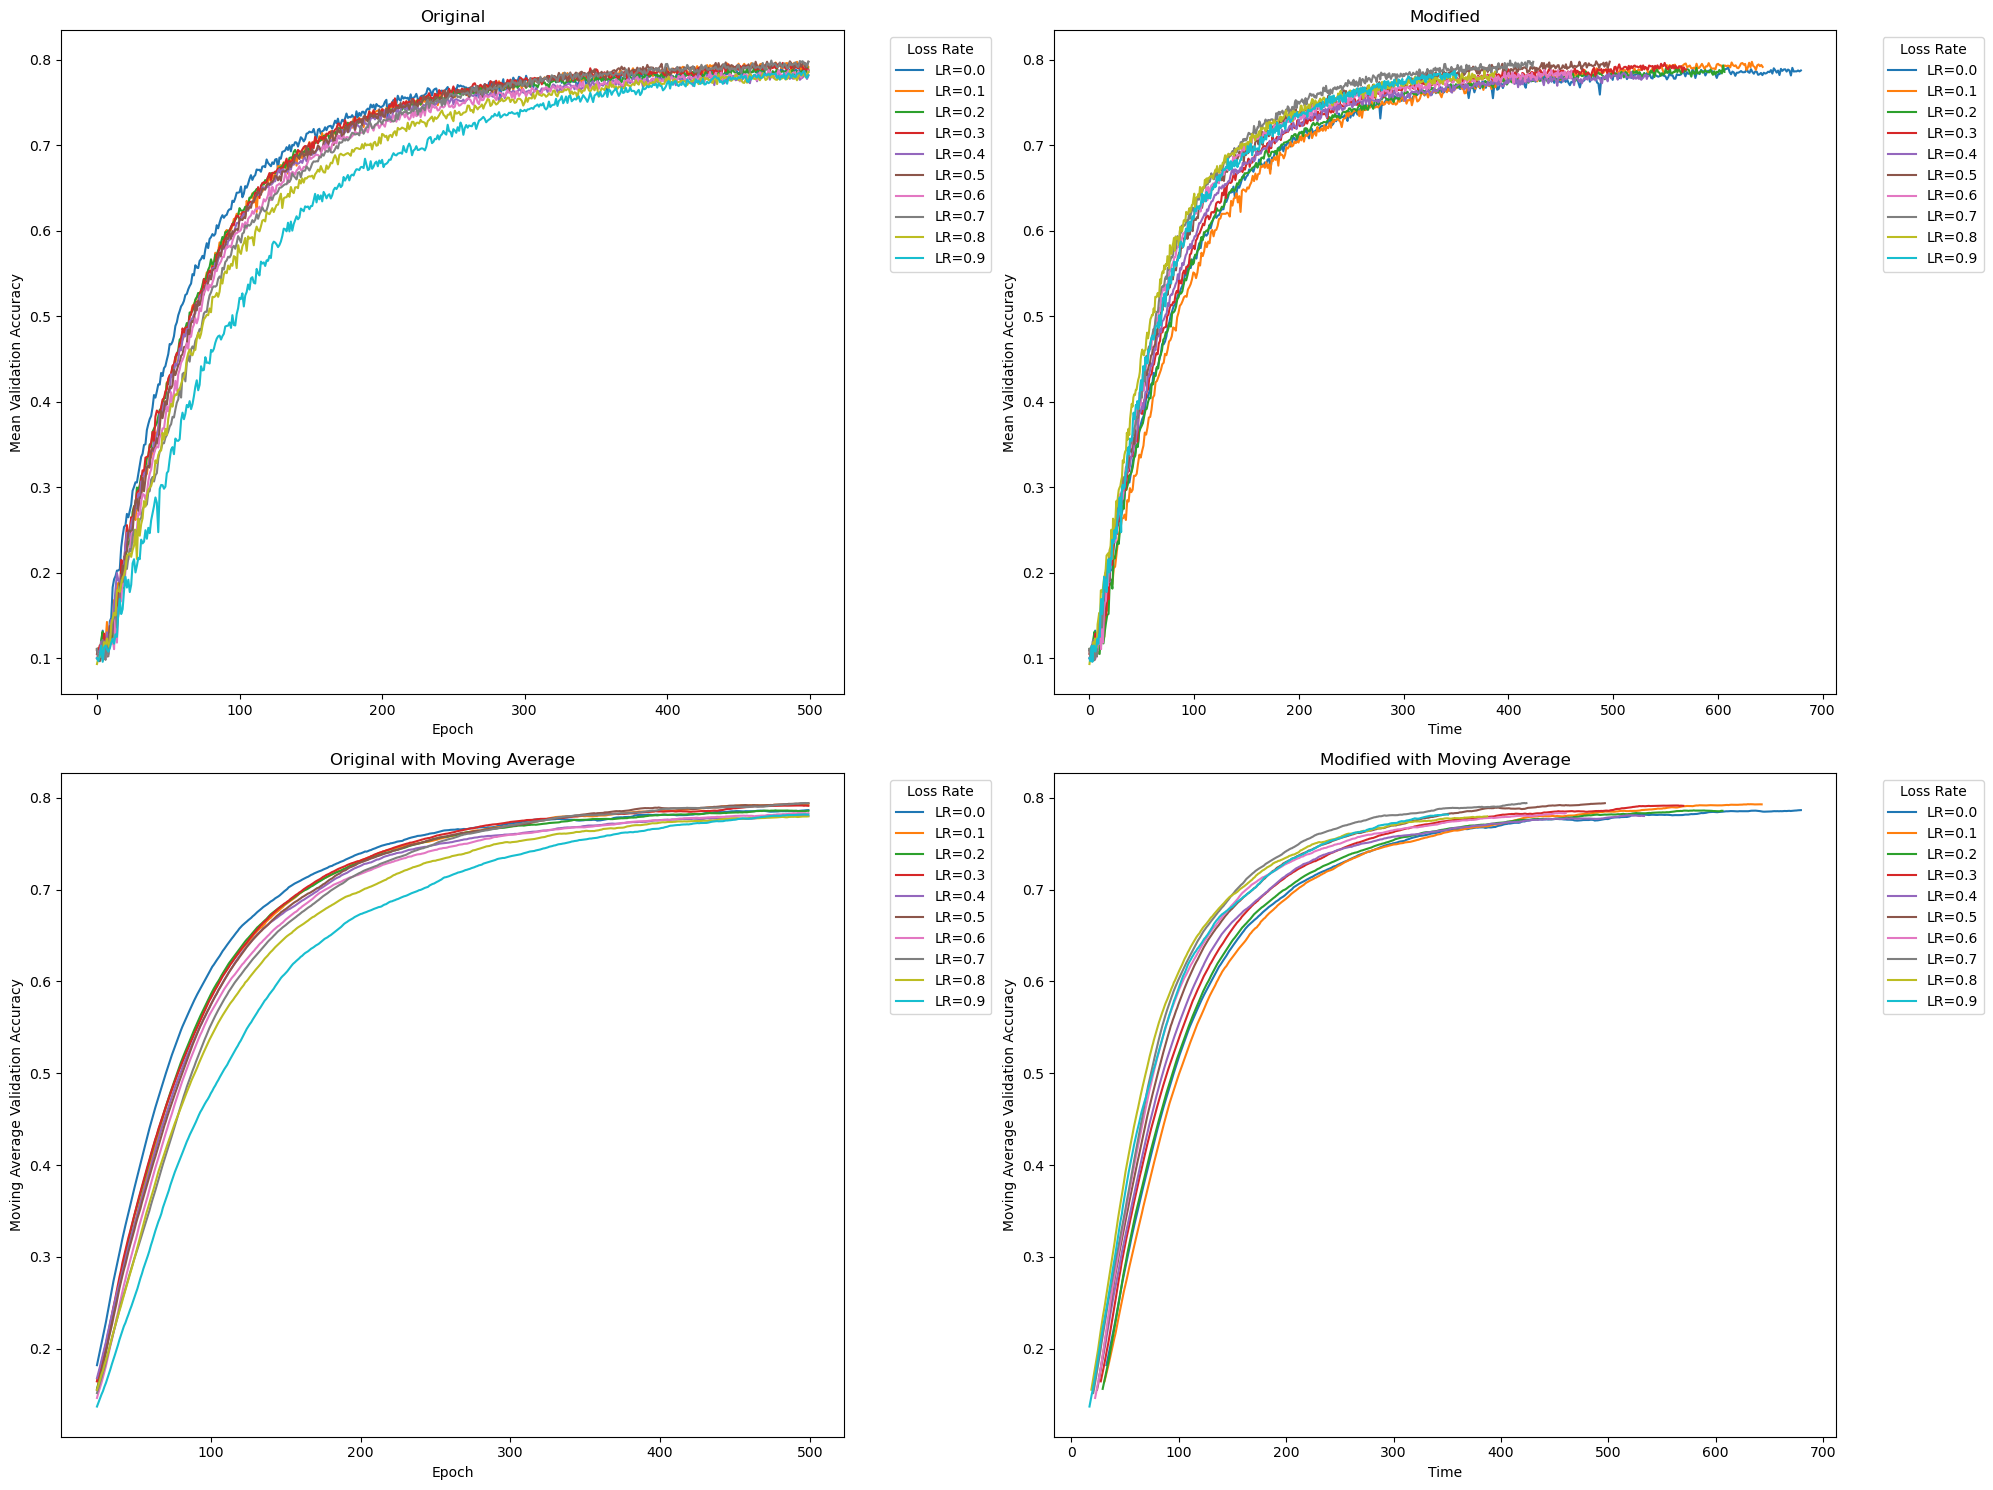

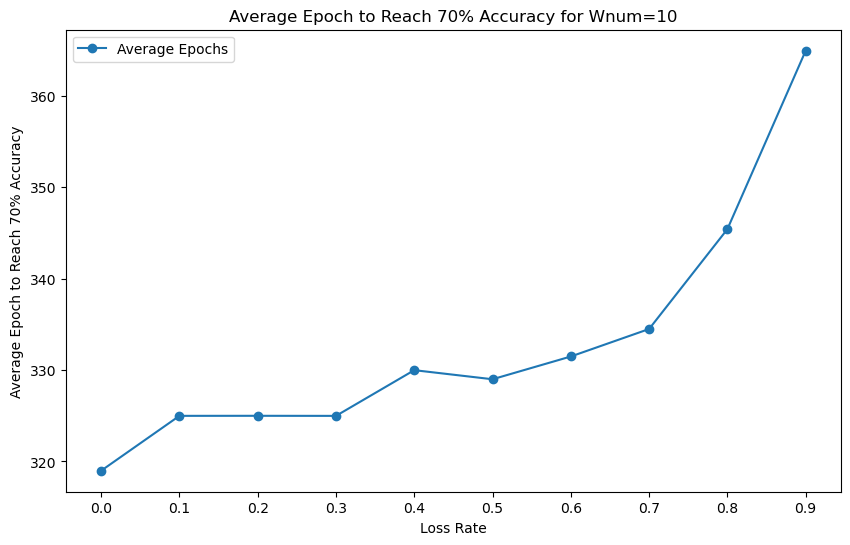

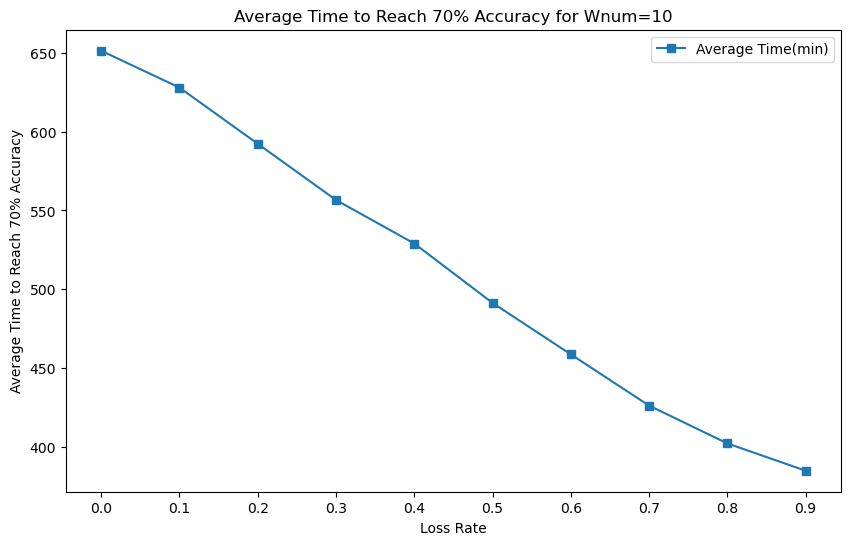

Average epochs to reach 70% accuracy for Wnum=10:
  LR=0.0: 318.99 epochs
  LR=0.1: 324.99 epochs
  LR=0.2: 325.00 epochs
  LR=0.3: 324.99 epochs
  LR=0.4: 329.99 epochs
  LR=0.5: 329.00 epochs
  LR=0.6: 331.49 epochs
  LR=0.7: 334.50 epochs
  LR=0.8: 345.43 epochs
  LR=0.9: 364.96 epochs


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the directory containing the folders with metrics.csv files
base_dir = './Nette_Use_zero_False__Use_avg_True'  # Modify this to the correct path

# Initialize an empty dataframe to store all metrics
all_metrics = pd.DataFrame()

# Loop through each folder and read all metrics.csv files
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        for i in range(1, 6):  # Assuming metrics1.csv to metrics5.csv
            csv_path = os.path.join(folder_path, f'metrics{i}.csv')
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                wnum = folder_name.split('_')[1]  # Extract Wnum value
                lr = folder_name.split('_')[2]    # Extract LR value
                df['Wnum'] = wnum.split('Wnum')[1]
                df['LR'] = lr.split('LR')[1]
                all_metrics = pd.concat([all_metrics, df], ignore_index=True)

# Calculate the mean val_acc for the same Wnum and LR
mean_metrics = all_metrics.groupby(['Wnum', 'LR', 'epoch']).mean().reset_index()

# Define the function to modify the x-axis values based on LR
def modify_x_axis(x_values, lr):
    return x_values * (25.5/40.5 + 15/20.5 * (1 - float(lr)))

# Define the function to modify the y-axis values based on LR
def modify_y_axis(y_values, lr):
    return y_values * (25.5/40.5 + 15/20.5 * (1 - float(lr)))*1.5
# Define the function to calculate the average epoch to reach 70% accuracy
def avg_epoch_to_reach_acc(data, target_acc=0.7):
    avg_epochs = {}
    for lr, grp in data.groupby('LR'):
        epochs_to_reach_acc = grp[grp['val_acc'] >= target_acc]['epoch']
        if not epochs_to_reach_acc.empty:
            avg_epochs[lr] = epochs_to_reach_acc.mean()
        else:
            avg_epochs[lr] = None  # If target accuracy is not reached
    return avg_epochs

# Define the function to calculate the moving average
def moving_average(data, window_percent=0.05):
    window_size = int(len(data) * window_percent)
    return data.rolling(window=window_size).mean()

# Plotting mean val_acc for all metrics in separate graphs for each Wnum
unique_wnum = mean_metrics['Wnum'].unique()

for wnum in unique_wnum:
    plt.figure(figsize=(20, 15))
    subset = mean_metrics[mean_metrics['Wnum'] == wnum]
    
    # Original plot
    plt.subplot(2, 2, 1)
    for key, grp in subset.groupby('LR'):
        plt.plot(grp['epoch'], grp['val_acc'], label=f'LR={key}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Validation Accuracy')
    plt.title('Original')
    plt.legend(title='Loss Rate', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Modified plot
    plt.subplot(2, 2, 2)
    for key, grp in subset.groupby('LR'):
        modified_epoch = modify_x_axis(grp['epoch'], key)
        plt.plot(modified_epoch, grp['val_acc'], label=f'LR={key}')
    plt.xlabel('Time')
    plt.ylabel('Mean Validation Accuracy')
    plt.title('Modified')
    plt.legend(title='Loss Rate', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Original plot with moving average
    plt.subplot(2, 2, 3)
    for key, grp in subset.groupby('LR'):
        moving_avg = moving_average(grp['val_acc'], window_percent=0.05)  # Adjust the window_percent as needed
        plt.plot(grp['epoch'], moving_avg, label=f'LR={key}')
    plt.xlabel('Epoch')
    plt.ylabel('Moving Average Validation Accuracy')
    plt.title('Original with Moving Average')
    plt.legend(title='Loss Rate', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Modified plot with moving average
    plt.subplot(2, 2, 4)
    for key, grp in subset.groupby('LR'):
        modified_epoch = modify_x_axis(grp['epoch'], key)
        modified_val_acc = moving_average(grp['val_acc'], window_percent=0.05)  # Adjust the window_percent as needed
        plt.plot(modified_epoch, modified_val_acc, label=f'LR={key}')
    plt.xlabel('Time')
    plt.ylabel('Moving Average Validation Accuracy')
    plt.title('Modified with Moving Average')
    plt.legend(title='Loss Rate', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    
    # Calculate and plot the average epoch to reach 70% accuracy for each LR
    avg_epochs = avg_epoch_to_reach_acc(subset)
    lrs = list(avg_epochs.keys())
    avg_epoch_values = [avg_epochs[lr] for lr in lrs]
    modified_avg_epoch_values = [modify_y_axis(epoch, lr) if epoch is not None else None for epoch, lr in zip(avg_epoch_values, lrs)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, avg_epoch_values, 'o-', label='Average Epochs')
    plt.xlabel('Loss Rate')
    plt.ylabel('Average Epoch to Reach 70% Accuracy')
    plt.title(f'Average Epoch to Reach 70% Accuracy for Wnum={wnum}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(lrs, modified_avg_epoch_values, 's-', label='Average Time(min)')
    plt.xlabel('Loss Rate')
    plt.ylabel('Average Time to Reach 70% Accuracy')
    plt.title(f'Average Time to Reach 70% Accuracy for Wnum={wnum}')
    plt.legend()
    plt.show()
    # Print the average epoch to reach 70% accuracy for each LR
    print(f'Average epochs to reach 70% accuracy for Wnum={wnum}:')
    for lr, avg_epoch in avg_epochs.items():
        if avg_epoch is not None:
            print(f'  LR={lr}: {avg_epoch:.2f} epochs')
        else:
            print(f'  LR={lr}: Target accuracy not reached')


In [26]:
import numpy as np
a=[[1,2],[3,4],[5,6]]
a[1]=None
a
for i in range(len(a)):
    print(a[i])
    if a[i]==None:
        a[i]=[0]

[np.array([g for g in grads if g is not None]).mean() for grads in a]
#
#a.mean()

[1, 2]
None
[5, 6]


[1.5, 0.0, 5.5]

In [7]:
a=[[1,2],[3,4],[5,6]]
list(zip(*a))

[(1, 3, 5), (2, 4, 6)]

In [42]:
[i for i in a]

[[1, 2], [3, 4], [5, 6]]

In [44]:
for i, e in enumerate(a):
    print(i,e)

0 [1, 2]
1 [3, 4]
2 [5, 6]


In [29]:
print(a)
b=a[0]

[[1, 2], [0], [5, 6]]


In [28]:
np.array(a)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.